In [1]:
# Combined surface detection and flattened tiff creation notebook
# 8/1/2024
# ACdata must be mounted for access to zarr datasets

In [2]:
import numpy
import json
import matplotlib.pyplot as plt
from tifffile import TiffFile,imread

In [3]:
from surface_detection import get_zarr_group,detect_surface

In [4]:
from skimage.io import imsave
def write_array_to_tiff(tiffpath,arr,exclude=None):
    for i in range(arr.shape[0]):
        if not (not exclude is None and i in exclude):
            imsave(tiffpath,arr[i,...],append=True,bigtiff=True)

# Function to get voxel resolution for a given mip level
def get_voxel_resolution(grp, mip_level):
    # Access the metadata
    metadata = grp.attrs.asdict()
    
    # Retrieve the voxel resolution for the specified mip level
    voxel_resolution = metadata['multiscales'][0]['datasets'][mip_level]['coordinateTransformations'][0]['scale']
    
    return voxel_resolution
            
def read_file(fpath):
    with TiffFile(fpath,is_ome=False) as tf:
        pg = tf.pages[0]
        data = numpy.zeros((pg.shape[0],pg.shape[1],len(tf.pages)),dtype=pg.dtype)
        for i,page in enumerate(tf.pages):
            data[:,:,i] = page.asarray()
    return data

In [5]:
# materialization routine
# surface is a 2-D array of shape (data.shape[0],data.shape[1])
# of int values which are coordinate shifts to shift each column (axis 2)
# to flatten one surface of the volume
def materialize_tiff(tiffpath,data,surface,surfsup=False):
    A = data
    G = surface
    B = numpy.zeros(A.shape,dtype=A.dtype)
    xdim = B.shape[2]
    if not surfsup:        
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g-10<0:
                    B[z,y,:] = A[z,y,:]
                else:
                    B[z,y,:xdim-(g-10)] = A[z,y,g-10:]
    else:
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g+10 < xdim:
                    B[z,y,xdim-(g+10):] = A[z,y,:g+10]
                else:
                    B[z,y,:] = A[z,y,:]
    write_array_to_tiff(tiffpath,B.transpose((2,1,0)))

In [32]:
# materialization routine
# surface is a 2-D array of shape (data.shape[0],data.shape[1])
# of int values which are coordinate shifts to shift each column (axis 2)
# to flatten one surface of the volume
def flatten_surface(data,surface,surfsup=False):
    A = data
    G = surface
    B = numpy.zeros(A.shape,dtype=A.dtype)
    xdim = B.shape[2]
    if not surfsup:        
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g-10<0:
                    B[z,y,:] = A[z,y,:]
                else:
                    B[z,y,:xdim-(g-10)] = A[z,y,g-10:]
    else:
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g+10 < xdim:
                    B[z,y,xdim-(g+10):] = A[z,y,:g+10]
                else:
                    B[z,y,:] = A[z,y,:]
    return B
    # write_array_to_tiff(tiffpath,B.transpose((2,1,0)))

In [43]:
# get mip data from zarr
zarr = "/ACdata/Users/kevin/exaspim_ome_zarr/output_exa4/test.zarr/"
tile = "tile_x_0002_y_0001_z_0000_ch_488"
grp = get_zarr_group(zarr,tile)

# :,:,: is for entire tile, but cutout can be made by indexing on spatial axes
miplvl = 4
mipdata = grp[miplvl][0,0,:,:,:].transpose((2,1,0))

In [57]:
write_array_to_tiff("mip4.tif",mipdata.transpose((2,1,0)))

/tmp/ipykernel_1347861/3376891948.py:5: UserWarning: mip4.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


In [44]:
resolution = get_voxel_resolution(grp, miplvl)
resolution = numpy.array([resolution[4],resolution[3],resolution[2]])
resolution


array([11.96799946, 11.96799959, 16.        ])

In [46]:
mipdata.shape

(888, 672, 384)

In [47]:
mipmax = numpy.max(mipdata,axis=2)

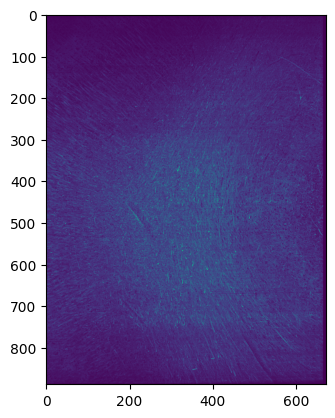

In [49]:
plt.imshow(mipmax)

In [50]:
# detect surface to flatten against (top: True, bottom: False)
# defines coordinate shift for every column of voxels to flatten one surface
surf_is_up = False
B = numpy.round(detect_surface(mipdata,surfsup=surf_is_up)).astype(int)

(888, 672)
1499


In [51]:
B


array([[190, 190, 190, ..., 116, 116, 116],
       [190, 190, 190, ..., 116, 116, 116],
       [190, 190, 190, ..., 116, 116, 116],
       ...,
       [215, 214, 212, ..., 179, 179, 179],
       [215, 214, 212, ..., 179, 179, 179],
       [216, 214, 212, ..., 179, 179, 179]])

In [58]:
B.shape

(672, 888)

157.27177679912054

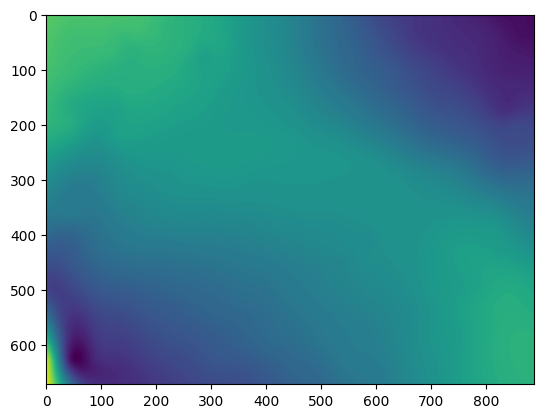

In [52]:
plt.imshow(B)
numpy.mean(B)

In [35]:
# flatten_bottom = flatten_surface(mipdata,B.transpose(),surfsup=surf_is_up)

In [36]:
# flatten_bottom.shape

(444, 336, 192)

In [53]:
# detect surface to flatten against (top: True, bottom: False)
# defines coordinate shift for every column of voxels to flatten one surface
surf_is_up = True
T = numpy.round(detect_surface(mipdata,surfsup=surf_is_up)).astype(int)

(888, 672)
1499


In [54]:
T

array([[181, 181, 182, ..., 232, 232, 232],
       [181, 181, 182, ..., 232, 232, 232],
       [181, 181, 182, ..., 232, 232, 232],
       ...,
       [200, 201, 201, ..., 293, 293, 293],
       [200, 201, 202, ..., 293, 293, 293],
       [200, 201, 202, ..., 293, 293, 293]])

In [59]:
T.shape

(672, 888)

261.59741828882454

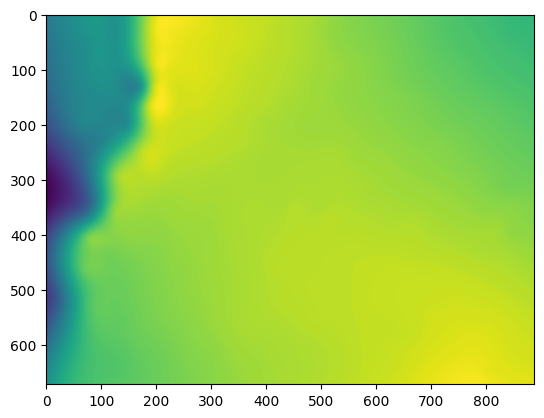

In [55]:
plt.imshow(T)
numpy.mean(T)

In [60]:
middle = numpy.round((B+T)/2).astype(int)
middle

array([[186, 186, 186, ..., 174, 174, 174],
       [186, 186, 186, ..., 174, 174, 174],
       [186, 186, 186, ..., 174, 174, 174],
       ...,
       [208, 208, 206, ..., 236, 236, 236],
       [208, 208, 207, ..., 236, 236, 236],
       [208, 208, 207, ..., 236, 236, 236]])

In [72]:
def compute_shifts(surface):
    # Compute shifts to flatten the surface
    reference_level = numpy.median(surface)
    shifts = surface - reference_level
    return shifts.astype(int)

def apply_shifts(volume, shifts):
    flattened_volume = numpy.zeros_like(volume)
    for z in range(volume.shape[0]):
        for y in range(volume.shape[1]):
            shift = shifts[z, y]
            if shift < 0:
                flattened_volume[z, y, :shift] = volume[z, y, -shift:]
            else:
                flattened_volume[z, y, shift:] = volume[z, y, :-shift]
    return flattened_volume

In [73]:
shifts = compute_shifts(middle.T)
shifts

array([[-29, -29, -29, ...,  -7,  -7,  -7],
       [-29, -29, -29, ...,  -7,  -7,  -7],
       [-29, -29, -29, ...,  -9,  -8,  -8],
       ...,
       [-41, -41, -41, ...,  21,  21,  21],
       [-41, -41, -41, ...,  21,  21,  21],
       [-41, -41, -41, ...,  21,  21,  21]])

In [76]:
shifts.shape, mipdata.shape

((888, 672), (888, 672, 384))

In [79]:
flattened_data = numpy.zeros_like(mipdata)


In [81]:
mipdata.shape[0],mipdata.shape[1],shifts[0,0]

(888, 672, -29)

In [85]:
for z in range(mipdata.shape[0]):
    for y in range(mipdata.shape[1]):
        shift = shifts[z, y]
        if shift < 0:
            flattened_data[z, y, :shift] = mipdata[z, y, -shift:]
        elif shift == 0:
            flattened_data[z, y, :] = mipdata[z, y, :]
        else:
            flattened_data[z, y, shift:] = mipdata[z, y, :-shift]

In [86]:
flattened_data.shape

(888, 672, 384)

In [88]:
mipdata.shape

(888, 672, 384)

In [87]:
write_array_to_tiff("flattened.tif",flattened_data.transpose((2,1,0)))

/tmp/ipykernel_1347861/3376891948.py:5: UserWarning: flattened.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


In [90]:
write_array_to_tiff("mip4.tif",mipdata.transpose((2,1,0)))

/tmp/ipykernel_1347861/3376891948.py:5: UserWarning: mip4.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


In [18]:
materialize_tiff(tiffpath="flat_mip5.tif",data=flatten_data,surface=T.transpose(),surfsup=surf_is_up)

/tmp/ipykernel_1347861/3376891948.py:5: UserWarning: flat_mip5.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)
